Contenido bajo licencia Creative Commons BY 4.0 y código bajo licencia MIT. © Juan Gómez y Nicolas Guarín-Zapata 2019. Este material es parte del curso Mecánica de los Medios Continuos en el programa de Ingeniería Civil de la Universidad EAFIT.

# Respuesta de una presa trapezoidal de concreto.
(Medios Continuos)

Considere la presa de concreto de forma trapezoidal mostrada en la figura:


<center>
    <img src="img/presa.svg"
         alt="Diagrama de la presa."
         style="width:400px">
</center>



y definida por los siguientes paramétros:

* $H_p $ : altura de la presa .

* $A_p$ : ancho de la pata.

* $A_c$ : ancho de la cresta.

Para efectos del modelo de análisis los paramétros para el rectangulo que representa el suelo se definen como:

* $H_s$ : profundidad del deposito de suelo.

* $D_l$ : distancia de la frontera izquierda medida desde la pata de la presa.

* $D_r$ : distancia de la fronetra derecha medida desde la pata de la presa.

<center>
    <img src="img/presa_dim.svg"
         alt="Diagrama de la presa."
         style="width:400px">
</center>


El material base para el concreto de la presa tiene las siguientes propiedades:

* Módulo de elasticidad: 50 GPa.

* Relación de Poisson: 0.20.

* Resistencia a la compresión: 60 MPa.

* Resistencia a la tensión: 10 MPa.

* Resistencia al corte : 15 MPa.

La presa se construirá sobre un basamento rocoso (basalto asumido elástico ) con las siguientes propiedades:

* Módulo de elasticidad: 60 GPa.

* Relación de Poisson: 0.20.

Se asume además que:

* La presa estará sometida a la acción de la presión hidrostática impartida por un fluido de peso especifico $\gamma = 9.8 \text{ kN/m}^3$ y dada por:

$$p = \gamma z$$

donde  $z$ es la distancia desde la superficie libre del fluido asumida en la misma cota de la cresta de la presa.

<div class="alert alert-warning">
    
**Herramienta de análisis**

Para determinar la respuesta de la presa se dispone de un programa de análisis por elementos finitos que permite calcular el campo de desplazamientos, tensiones y deformaciones sobre todo el dominio. El programa asume condiciones de deformación plana (plane strain) y permite aplicar cargas nodales sobre la superficie así como fuerzas distribuidas en el dominio representativas de fuerzas de cuerpo.
</div>



## Actividades.

**1)** Asumiendo que $A_c = A_p$:

* (i) Determine la respuesta de la presa a una carga lateral en su cresta.

* (ii) Determine la respuesta de la presa a una carga uniformemente distribuida de magnitud $p = \gamma H_p$ sobre la superficie de la presa en contacto con el fluido.

* (iii) Determine la respuesta de la presa a una carga con variación lineal (equivalente al empuje del agua sobre la presa).

Compare los resultados de cada uno de los análisis con la respectiva solución de resistencia de materiales (teoría de vigas). Adicionalmente:

(a) Describa los cambios de la solución entre los casos (i) al (iii).

(b) Usando argumentos de tipo mecánico explique los cambios identificados en el numeral anterior.

**2)** Repita el análisis (iii) pero adicionando ahora fuerzas de cuerpo correspondientes al peso propio del concreto. Asuma que el peso especifico del concreto es **2.3 veces el del fluido**.

**3)** Considere ahora 3 valores diferentes para el ancho de la pata $A_p$. Usando argumentos de tipo mecánico explique el efecto de este paramétro en la respuesta.

**4)** Usando los paramétros geometricos y propiedades de los materiales dadas al inicio del NB indique si la presa falla o no falla. En caso de que esta falle indique la localización de los puntos de falla y los respectivos modos de falla. En caso de que esta no presente falla indique el factor de seguridad en cada caso.

## Análisis de tensiones.

In [48]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import meshio
import solidspy.preprocesor as msh
import solidspy.assemutil as ass
import solidspy.postprocesor as pos
import solidspy.solutil as sol
import aux_functions as aux

A continuación se ejectua el análisis por elementos finitos mediante el cual se determinan los campos de desplazamientos, deformaciones y tensiones. Un análisis por elementos finitos se puede resumir en los sigueintes pasos:

* Se lee el modelo con la información de nudos, elementos, materiales y cargas.

* Se determinan las reglas de ensamblaje del sistema de ecuaciones.

* Se ensambla la matriz de coeficientes del sistema de ecuaciones.

* Se ensambla el vector de cargas (o condiciones conocidas) para el sistema de ecuaciones. En este paso se decide si se consideran o no las fuerzas de cuerpo.

* Se resuelve el sistema de ecuaciones.

* Se post-procesan los resultados y se visualiza la solución.


<div class="alert alert-warning">

**Notas:**

* Las diferentes mallas deben estar almacenadas en una carpeta denominada **files** dentro de su carpeta de trabajo. Cada malla esta representada por 2 archivos correspondientes a la definición de la geometría del modelo (.geo) y su discretización en elementos finitos (.msh) respectivamente. Para cambiar algún paramétro del modelo localice el paramétro en el archivo .geo, realice los cambios y re-malle el modelo.

* La altura y ancho de la cresta de la presa afectan el peso propio y las cargas de empuje del fluido. No olvide cambiarlos de manera consistente en el archivo .geo y en el llamado a la rutina de carga.

* Para activar las fuerzas de cuerpo cambie el parametro body a True
</div>


In [49]:
%run -i files/snippet1.py

In [50]:
H_p   = 100.0
A_c   = 30.0
gamma = 9.8e3
cargas = aux.dam_loading(cells, cell_data, 3000, points, 0.0, gamma, H_p)
#cargas = aux.uniform_loading(cells, cell_data, 3000, points, gamma, H_p)
np.savetxt("files/Dloads.txt", cargas, fmt=("%d", "%.3g", "%.3g"))

In [51]:
%run -i files/snippet2.py

In [52]:
body = False
%run -i files/snippet3.py

## Pos-procesamiento

En el post-procesamiento, además del calculo y visualización del campo de desplazamientos, se determinan las deformaciones y tensiones. La rutina `filtered()` disponible en el modulo `aux_functions` permite usar filtros para visualizar zonas de la malla en las que se excede cierto valor de alguno de los campos.

<IPython.core.display.Javascript object>


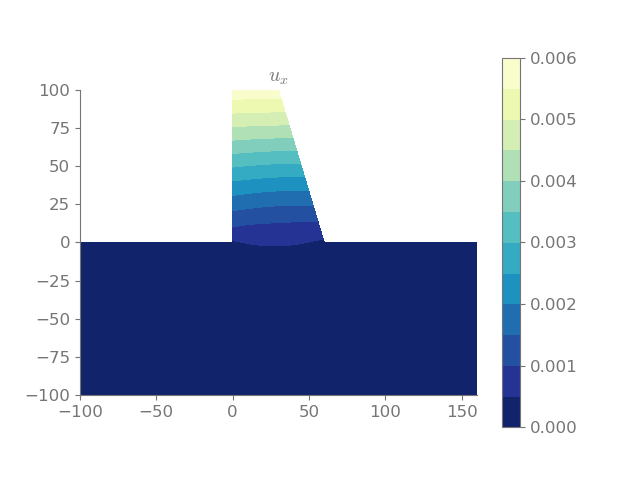

<IPython.core.display.Javascript object>


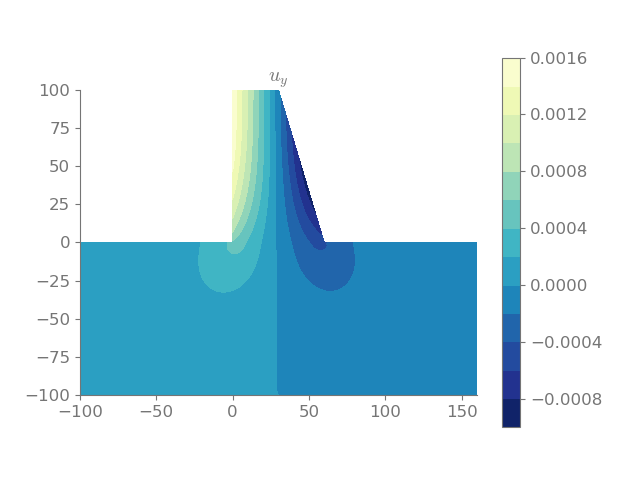

<IPython.core.display.Javascript object>


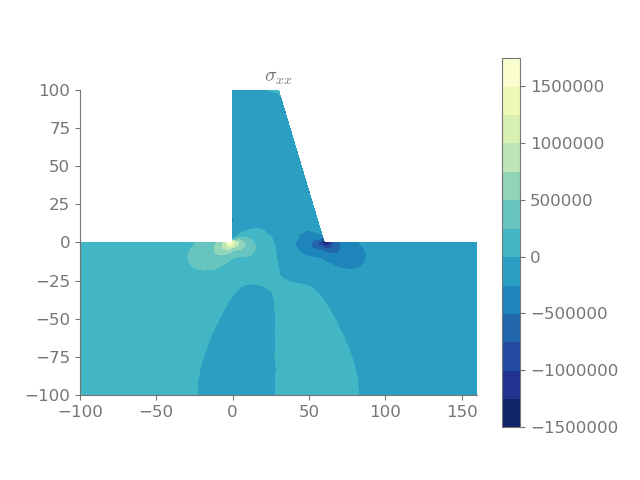

<IPython.core.display.Javascript object>


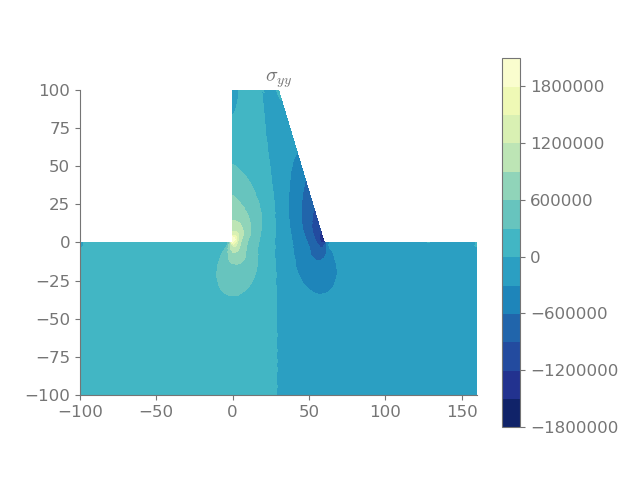

<IPython.core.display.Javascript object>


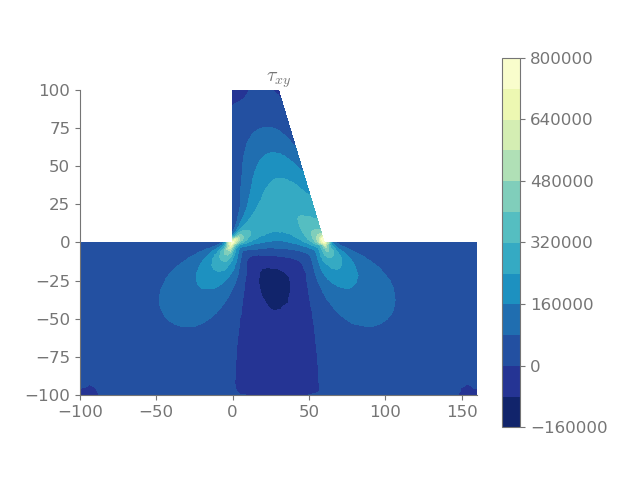

In [53]:
E_nodes, S_nodes = pos.strain_nodes(nodes, elements, mats, UC)
pos.fields_plot(elements, nodes, UC, S_nodes=S_nodes)

### Tensiones principales

Las tensiones principales se calculan de acuerdo con

$$\sigma^{\max,\, \min} = \tau_{\max}\pm\sigma_c$$

donde el cortante máximo $\tau_{\max}$ está dado por:

$$\tau_{\max}^2 = \left(\frac{\sigma_x - \sigma_y}{2}\right)^2 + \tau_{xy}^2$$

y la componente hidrostática del tensor es

$$\sigma_c = \frac{\sigma_x + \sigma_y}{2}.$$


In [54]:
eigs1, eigs2, vecs1, vecs2 = pos.principal_dirs(S_nodes)
TAO = np.abs(eigs1 - eigs2)

### $\sigma^1$

<IPython.core.display.Javascript object>


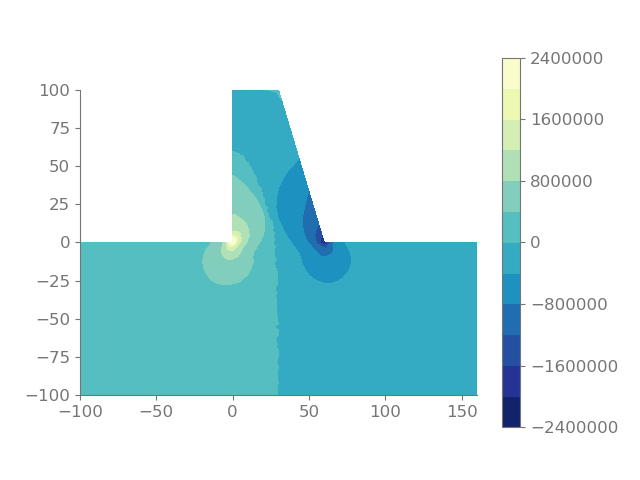

In [55]:
pos.plot_node_field(eigs1, nodes, elements, plt_type="contourf", levels=12)

<IPython.core.display.Javascript object>


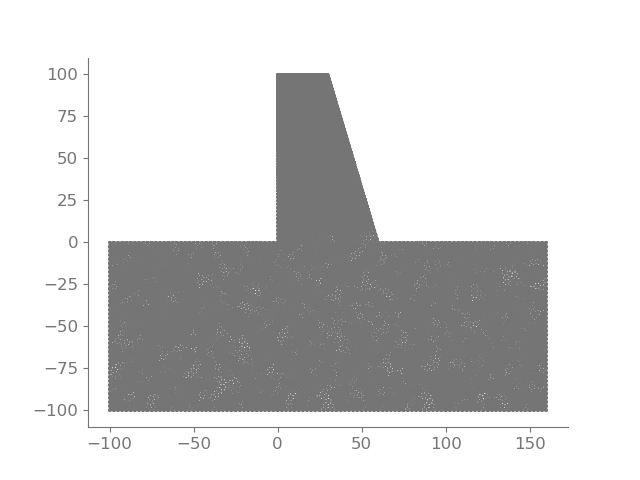

In [56]:
sigR_c = -60.0e6
aux.filtered(nodes, elements, eigs1, sigR_c)

### $\sigma^2$

In [57]:
#pos.plot_node_field(eigs2, nodes, elements, plt_type="contourf", levels=12)

<IPython.core.display.Javascript object>


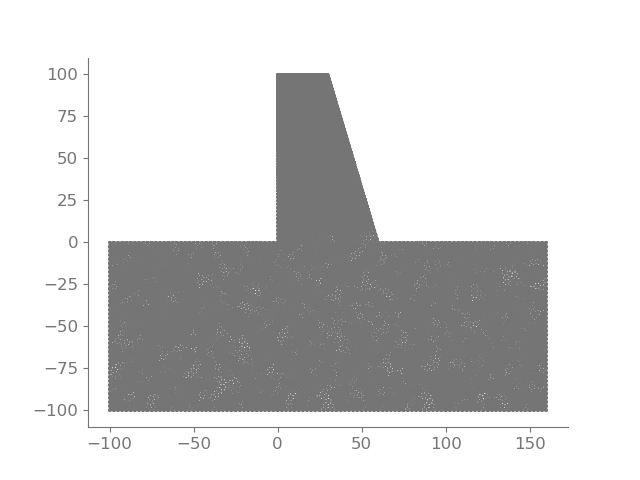

In [58]:
sigR_t = 10.0e6
aux.filtered(nodes, elements, eigs2, sigR_t)

### $\tau^{\max}$

<IPython.core.display.Javascript object>


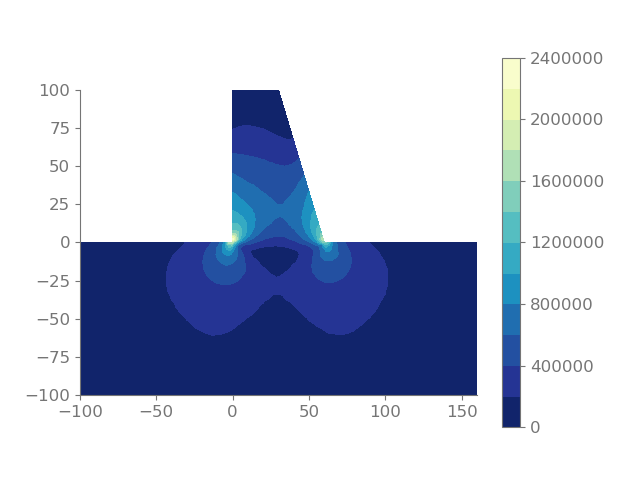

In [59]:
pos.plot_node_field(TAO, nodes, elements, plt_type="contourf", levels=12)

<IPython.core.display.Javascript object>


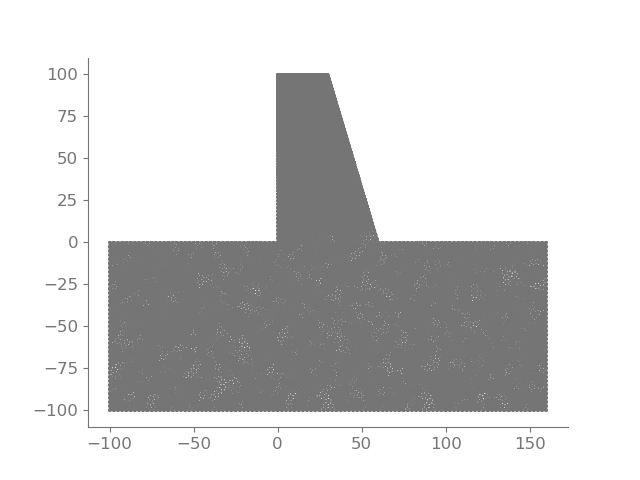

In [60]:
taoR = 15.0e6
aux.filtered(nodes, elements, TAO, taoR)

## Algunas unidades y equivalencias útiles

* $1 \quad \text{ N} = 1\quad \text{ kg m/s}^2$.

* $1\quad \text{ Pa} = 1 \text{ N/m}^2$.

* $1\quad \text{ kPa} = 1 \times 10^3 \text{ Pa}$.

* $1\quad \text{ MPa} = 1 \times 10^6 \text{ Pa}$.

* $1\quad \text{ GPa} = 1 \times 10^9 \text{ Pa}$.

## Mapa de lineas
El mapa de lineas y de puntos útil para la manipulación del modelo en Gmsh es el siguiente.

<center><img src="img/dam_map.png" alt="files" style="width:500px"></center>

### Referencias

* Juan Gómez, Nicolás Guarín-Zapata (2018). SolidsPy: 2D-Finite Element Analysis with Python, <https://github.com/AppliedMechanics-EAFIT/SolidsPy>.

In [61]:
from IPython.core.display import HTML
def css_styling():
    styles = open('./nb_style.css', 'r').read()
    return HTML(styles)
css_styling()